# The project

In this opportunity we'll go through the analysis of the dataset available at https://www.kaggle.com/thoughtvector/customer-support-on-twitter/ which contains several tweets from the customer support service of multiple companies around the globe. Essentially we're going to be focused on how the service is, based on the tweets obviously, how they can be improved in a business scenario and how the clients express themselves about the service. At the end, we'll perform topic modeling to find out what are the hottest topics the clients request assistance for.

We won't go through classification, only topic modeling. The reason is because we only want to explore the service and provide some conclusions together with possible solutions to improve the overall support and not to develop solutions, just infer them. We'll get to the point where, if the business would require it, the data would be ready for predicting automated responses (maybe implementing chatbots) or just provide links with how-to articles to increase the self-resolution.

We'll show how the dataset is composed and then will deep dive into it from the most general to the most specific.

# Imports

In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
from sklearn.decomposition import NMF, LatentDirichletAllocation
import warnings
warnings.filterwarnings('ignore')

# Data Exploration

We'll go through the dataset and select the most appropiate customer service tweets for our purposes

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/customer-support-on-twitter/sample.csv
/kaggle/input/customer-support-on-twitter/twcs/twcs.csv


In [3]:
tweets = pd.read_csv('/kaggle/input/customer-support-on-twitter/twcs/twcs.csv')
tweets[0:10]

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
5,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0
6,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN
7,11,sprintcare,False,Tue Oct 31 22:10:35 +0000 2017,@115713 This is saddening to hear. Please shoo...,NaN,12.0
8,12,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0
9,15,sprintcare,False,Tue Oct 31 20:03:31 +0000 2017,@115713 We understand your concerns and we'd l...,12,16.0


In [4]:
support_services = tweets['author_id'].value_counts()
support_services.sort_index(ascending=False,inplace=True)
support_services = support_services[:108]

## Customer service interactions by company

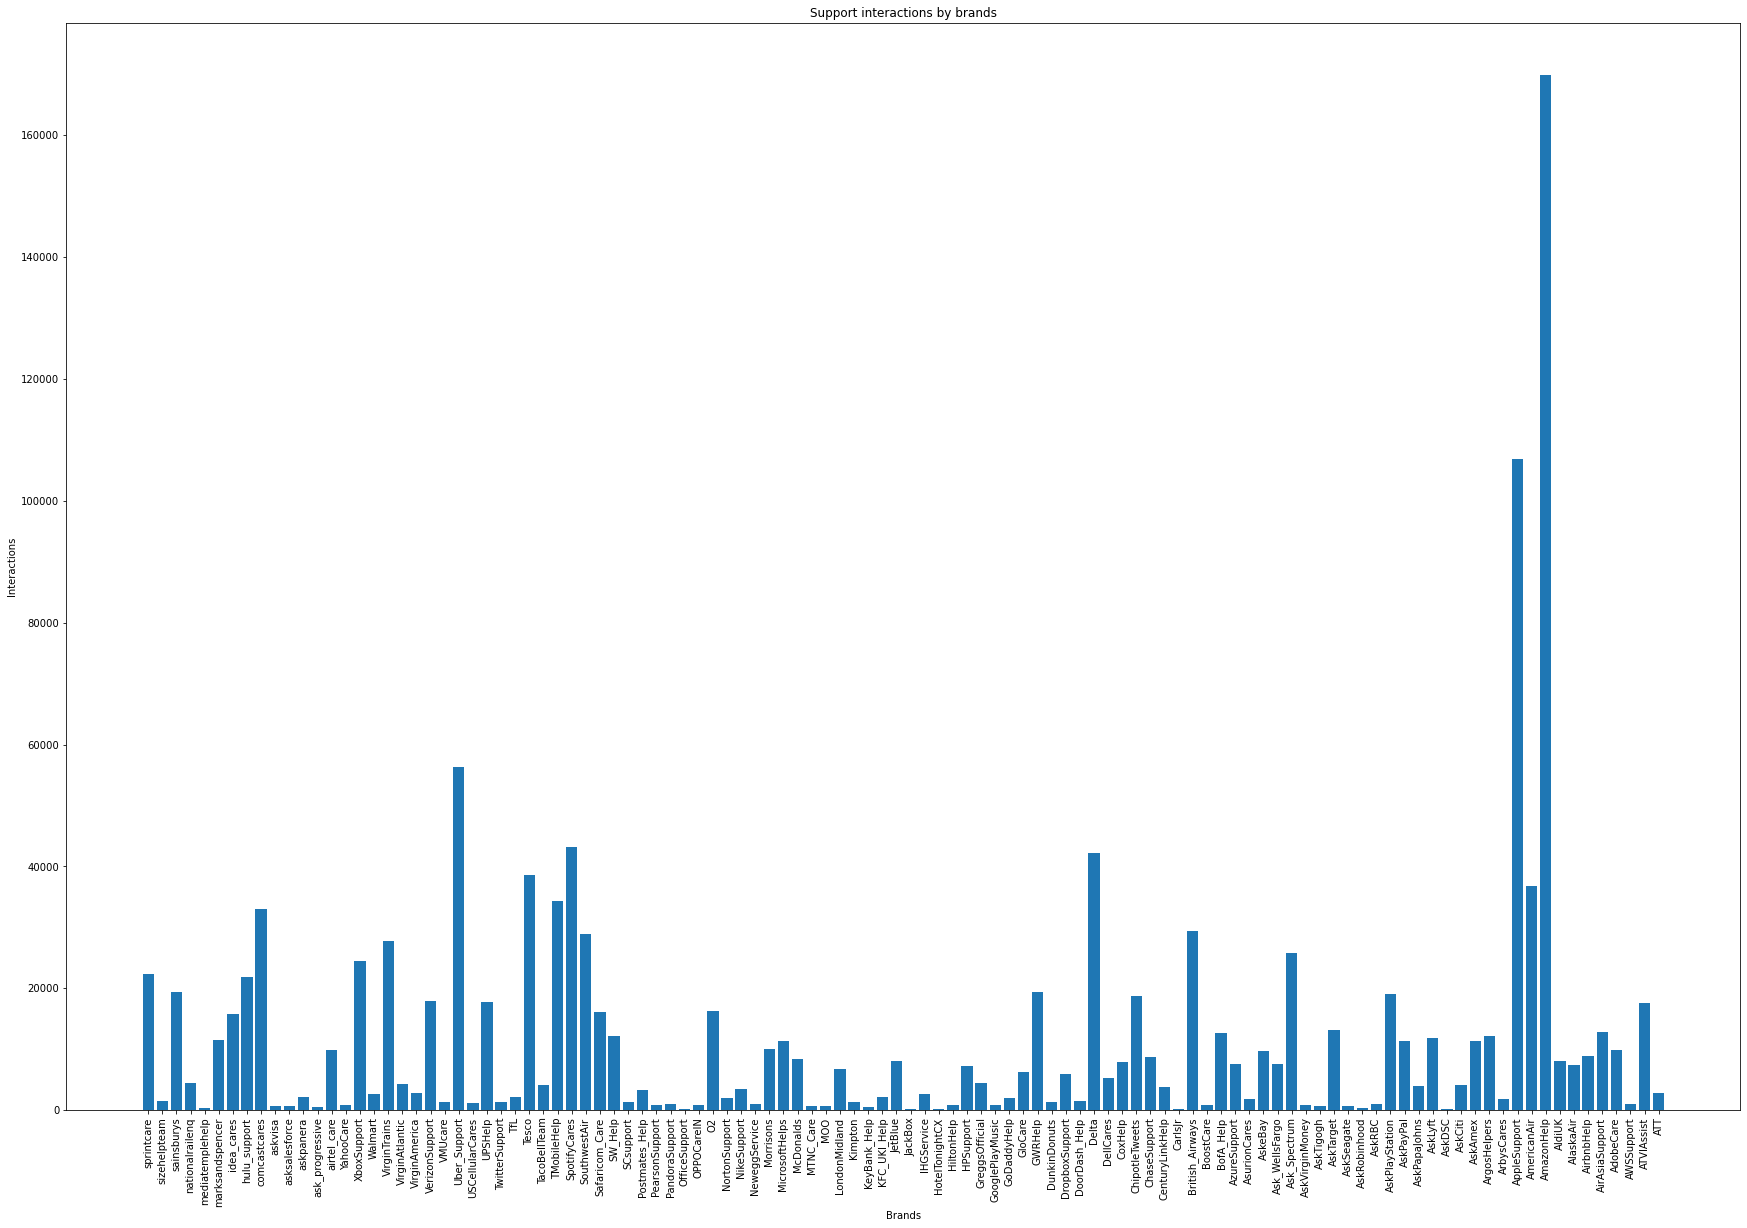

In [5]:
%matplotlib inline

plt.figure(figsize=(30,20))
plt.title('Support interactions by brands')
plt.xlabel('Brands')
plt.ylabel('Interactions')
plt.bar(list(support_services.index.values),list(support_services.values))
plt.xticks(rotation=90)
plt.show()

# Customer service data selection

Even when it's more than obvious that the majority of interactions are made by AmazonHelp and AppleSupport, we've selected **ChaseSupport** because it handles interactions and inquiries about **money and transactions**, which are very sensitive matters and it's where we can find more interesting data, because when talking about money, costumer support services must be very keen keeping the clients happy to avoid money loss.

## ChaseSupport data preprocessing

In [6]:
chase_support = tweets[tweets['author_id']=='ChaseSupport']

In [7]:
chase_support.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
916,1490,ChaseSupport,False,Tue Oct 31 22:23:08 +0000 2017,@116014 2/2 to the merchant's site to make the...,1491,1492.0
919,1493,ChaseSupport,False,Tue Oct 31 22:23:08 +0000 2017,"@116014 1/2 Hello, in order to get the cash ba...",NaN,1492.0
920,1494,ChaseSupport,False,Tue Oct 31 22:10:44 +0000 2017,@116015 We appreciate the kind words. If you h...,NaN,1495.0
922,1496,ChaseSupport,False,Tue Oct 31 22:09:45 +0000 2017,@116017 I’d like to review this further for yo...,NaN,1497.0
924,1498,ChaseSupport,False,Tue Oct 31 22:05:56 +0000 2017,@116018 We're glad we were able to help! ^JG,NaN,1499.0


## We need to place every customer service interaction with its corresponding client's inquiry/request

In [8]:
chase_support['interaction_tweet'] = ''
chase_support['interaction_author'] = ''
chase_support['interaction_tweet_at'] = ''

In [9]:
chase_support.dropna(subset=['tweet_id', 'in_response_to_tweet_id'],inplace=True)
chase_support.reset_index(drop=True,inplace=True)

In [10]:
for i in range(len(chase_support)):
    chase_support.at[i, 'interaction_tweet'] = str(list(tweets[tweets['tweet_id']==int(chase_support.iloc[i]['in_response_to_tweet_id'])]['text'])).strip("[']")
    chase_support.at[i, 'interaction_author'] = str(list(tweets[tweets['tweet_id']==int(chase_support.iloc[i]['in_response_to_tweet_id'])]['author_id'])).strip("[']") 
    chase_support.at[i, 'interaction_tweet_at'] = str(list(tweets[tweets['tweet_id']==int(chase_support.iloc[i]['in_response_to_tweet_id'])]['created_at'])).strip("[']")

In [11]:
chase_support.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,interaction_tweet,interaction_author,interaction_tweet_at
0,1490,ChaseSupport,False,Tue Oct 31 22:23:08 +0000 2017,@116014 2/2 to the merchant's site to make the...,1491,1492.0,Hi @ChaseSupport do I have to go through the C...,116014,Tue Oct 31 22:15:52 +0000 2017
1,1493,ChaseSupport,False,Tue Oct 31 22:23:08 +0000 2017,"@116014 1/2 Hello, in order to get the cash ba...",NaN,1492.0,Hi @ChaseSupport do I have to go through the C...,116014,Tue Oct 31 22:15:52 +0000 2017
2,1494,ChaseSupport,False,Tue Oct 31 22:10:44 +0000 2017,@116015 We appreciate the kind words. If you h...,NaN,1495.0,"""I've had some ups and downs from banking with...",116015,Tue Oct 31 21:00:04 +0000 2017
3,1496,ChaseSupport,False,Tue Oct 31 22:09:45 +0000 2017,@116017 I’d like to review this further for yo...,NaN,1497.0,"""Hey @116016 we're gonna need to talk about al...",116017,Tue Oct 31 21:58:55 +0000 2017
4,1498,ChaseSupport,False,Tue Oct 31 22:05:56 +0000 2017,@116018 We're glad we were able to help! ^JG,NaN,1499.0,@ChaseSupport Just got off the phone with them...,116018,Tue Oct 31 22:01:14 +0000 2017


Let's see how an interaction looks like

In [12]:
chase_support.iloc[0]['interaction_tweet']

'Hi @ChaseSupport do I have to go through the Chase Online Ultimate Rewards webpage to get the extra cash back when I shop?'

In [13]:
chase_support.iloc[1]['text']

"@116014 1/2 Hello, in order to get the cash back, you'll need to click the link from the Ultimate Rewards website. You'll be routed"

In [14]:
chase_support.iloc[0]['text']

"@116014 2/2 to the merchant's site to make the purchase. ^BG"

In [15]:
chase_support.dropna(subset=['interaction_tweet_at'],inplace=True)
chase_support.shape

(8714, 10)

Now we have 8714 interactions completely clean and from only one support provider.

# Exploring the ChaseSupport interactions
<br>
Let's suppose the management is needing to overview the customer support interactions. This could be to know how to balance the agents' shifts to deliver a better service and avoid any kind of backlog.<br>
Is there any particular day of the week when occurs more customer inquiries than others? 
<br>Is there any peak of the day when the interactions increase?
<br>What is the day of the month when most of the inquiries happen?<br><br>If any peak is found, management could consider to reorganize the agents' shifts so they cover the service in a better way.

## Interactions by days of the week - Distribution

In [16]:
days = chase_support['interaction_tweet_at'].str.extractall(r'(^\w+)').values

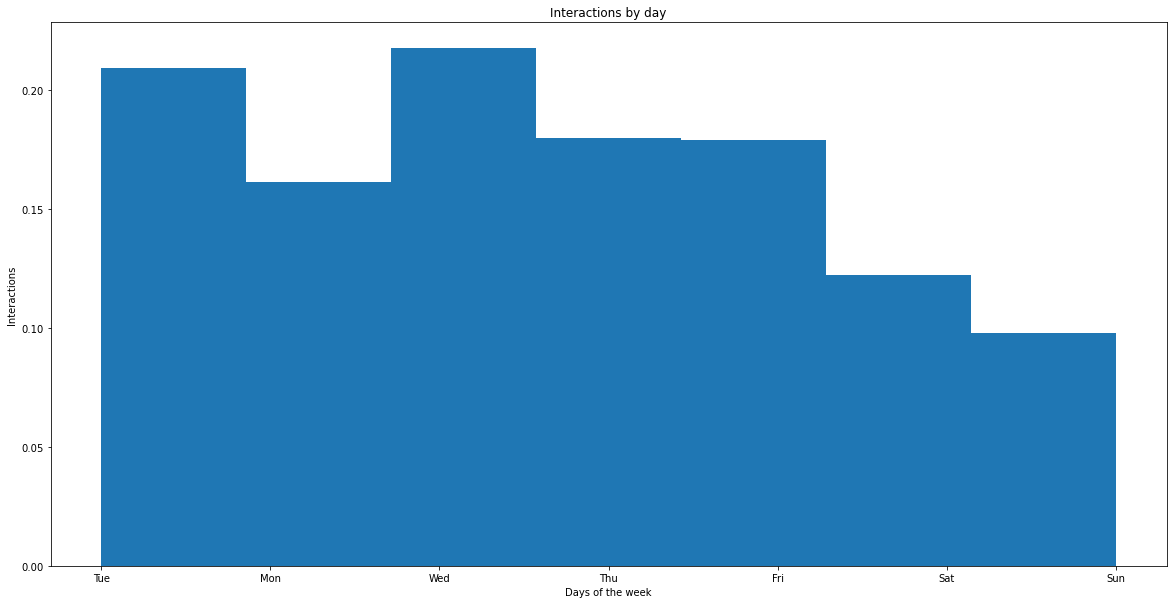

In [17]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.title('Interactions by day')
plt.xlabel('Days of the week')
plt.ylabel('Interactions')
plt.hist(days,bins=7,histtype='stepfilled',density=True)
plt.show()

The most busy days are Tuesday and Wednesday, as you could see. Management could have more agents these days to avoid delay in the service. Let's move on and see the rest of the distributions.

## Interactions by hours of the day - Distribution

In [18]:
time = chase_support['interaction_tweet_at'].str.extractall(r'(\s\d{1,2}[:])').values
hours = []
for i in range(len(time)):
    hours.append(int(time[i][0].strip(' :')))

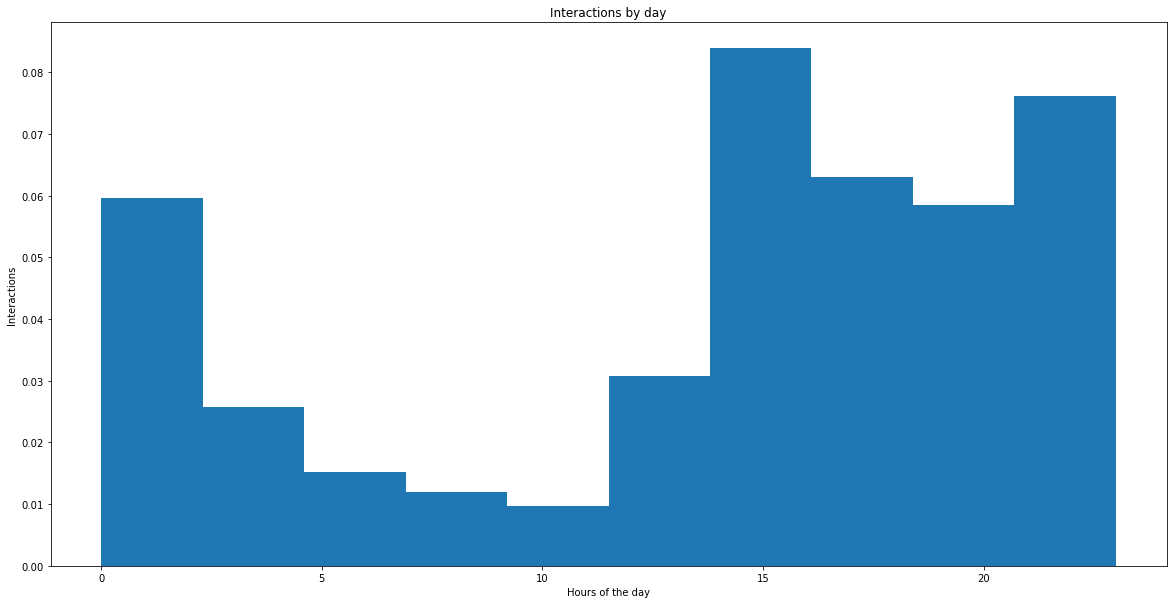

In [19]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.title('Interactions by day')
plt.xlabel('Hours of the day')
plt.ylabel('Interactions')
plt.hist(hours,histtype='stepfilled',density=True)
plt.show()

The peaks of the day happen at 15 and 21 hours, but in general the most busy frame is since 15 to 21 hours though. Those would be the hours when most of the workforce must be deployed in order to reduce the time-to-response and keep a good customer-satisfaction. Also, team lunch-breaks can be taken from 11 to 14 without the risk of degrade the service,

## Interactions by days of the month - Distribution

In [20]:
dates = chase_support['interaction_tweet_at'].str.extractall(r'(\D{3}\s\d{1,2})').values
days_of_month = []
for i in range(len(dates)):
    days_of_month.append(int(dates[i][0][-2:]))
days_of_month.sort()

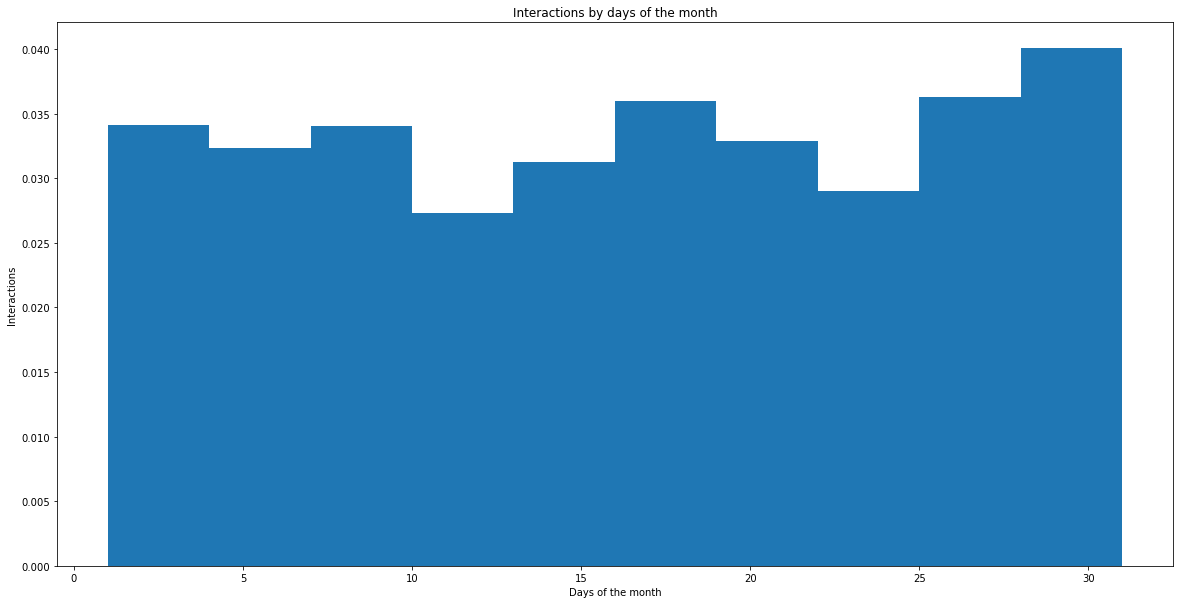

In [21]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.title('Interactions by days of the month')
plt.xlabel('Days of the month')
plt.ylabel('Interactions')
plt.hist(days_of_month,histtype='stepfilled',density=True)
plt.show()

Even when it looks to have a normal distribution, you can see the peak of interactions occurs at the end of the month, what is expected - It's pay day.

## What about the time-to-response? How long does it take to get an answer from ChaseSupport?

In [22]:
chase_support['Client interaction time'] = chase_support['interaction_tweet_at'].str.extract(r'(\d{1,2}[:]\d{1,2}[:]\d{1,2})').values
chase_support['Support interaction time'] = chase_support['created_at'].str.extract(r'(\d{1,2}[:]\d{1,2}[:]\d{1,2})').values
chase_support['TTR'] = np.nan

In [23]:
chase_support.drop(chase_support.index[[8348,436]],inplace=True)
chase_support.reset_index(drop=True,inplace=True)

In [24]:
for i in range(len(chase_support)):
    chase_support.at[i, 'TTR'] = pd.Timestamp(chase_support.iloc[i]['created_at']) - pd.Timestamp(chase_support.iloc[i]['interaction_tweet_at'])

In [25]:
chase_support.dropna(subset=['TTR'],inplace=True)
chase_support.reset_index(drop=True,inplace=True)
str(chase_support['TTR'].astype('timedelta64[s]').mean())

'0 days 04:52:35.305536'

### The average ChaseSupport Time-To-Respond is **4 hours 52 minutes** - a lot.
<br> This opens several questions such as **what is the recurrent issue that takes more time to be resolved?** or **What does a sentiment analysis would evidence about this response time if the data would be labeled?** Is there any topic that ChaseSupport could improve to reduce the response time?

Let's move on and see what else we can find out.

### What has been the most delayed response?

In [26]:
str(chase_support['TTR'].astype('timedelta64[s]').max())

'4 days 11:15:54'

### 4 days is the longest time an agent took to reply one of the customers. Let's deep dive into these cases.

In [27]:
chase_support.sort_values(by=['TTR'],ascending=False)[0:10]

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,interaction_tweet,interaction_author,interaction_tweet_at,Client interaction time,Support interaction time,TTR
7811,2778354,ChaseSupport,False,Tue Nov 21 16:00:07 +0000 2017,@776182 We're glad you are enjoying the new AT...,2778355,2778356.0,Chase ATMs finally give the option to dispense...,776182,Fri Nov 17 04:44:13 +0000 2017,04:44:13,16:00:07,4 days 11:15:54
8699,2986680,ChaseSupport,False,Tue Nov 21 16:23:26 +0000 2017,"@823527 Generally, if the account is left at a...",NaN,2986681.0,"""chase CLOSED MY ACCOUNT because i haven't use...",823527,Fri Nov 17 06:14:56 +0000 2017,06:14:56,16:23:26,4 days 10:08:30
7814,2778361,ChaseSupport,False,Tue Nov 21 15:51:58 +0000 2017,@776185 I'm from @ChaseSupport and would like ...,NaN,2778362.0,I knew we should’ve switched or bank from chas...,776185,Fri Nov 17 10:08:44 +0000 2017,10:08:44,15:51:58,4 days 05:43:14
7809,2778350,ChaseSupport,False,Tue Nov 21 16:11:00 +0000 2017,@776180 I'll certainly share your thoughts on ...,NaN,2778351.0,"As my savings grew, my monthly interest paymen...",776180,Fri Nov 17 13:20:26 +0000 2017,13:20:26,16:11:00,4 days 02:50:34
7840,2781452,ChaseSupport,False,Tue Nov 21 16:19:40 +0000 2017,@369060 I hope no inconvenience was caused by ...,NaN,2781453.0,Since when does Chase bank not open until 9?,369060,Fri Nov 17 13:45:08 +0000 2017,13:45:08,16:19:40,4 days 02:34:32
7760,2754423,ChaseSupport,False,Mon Nov 20 20:52:26 +0000 2017,@770983 We'd like to know why you feel this wa...,NaN,2754424.0,Definitely not fucking with Chase bank no more,770983,Thu Nov 16 19:42:22 +0000 2017,19:42:22,20:52:26,4 days 01:10:04
7753,2754411,ChaseSupport,False,Mon Nov 20 21:01:00 +0000 2017,@770980 This is never the type of experience w...,NaN,2754412.0,Having Chase Bank has become such an inconveni...,770980,Thu Nov 16 23:02:10 +0000 2017,23:02:10,21:01:00,3 days 21:58:50
7645,2727640,ChaseSupport,False,Mon Nov 20 13:25:00 +0000 2017,"@288407 Hi, I see you mentioned Chase in your ...",NaN,2727641.0,I love chase 😢 best bank in the whole world,288407,Thu Nov 16 15:56:58 +0000 2017,15:56:58,13:25:00,3 days 21:28:02
7649,2727648,ChaseSupport,False,Mon Nov 20 13:15:38 +0000 2017,@764861 We're sorry to hear this. We can certa...,NaN,2727649.0,Chase atm always giving me ripped bills,764861,Thu Nov 16 20:20:26 +0000 2017,20:20:26,13:15:38,3 days 16:55:12
4019,1695971,ChaseSupport,False,Sat Feb 28 17:13:00 +0000 2015,@514522 1/2 Though we’re not supporting Master...,1695972,1695973.0,"""@116016 1 million. Great for you guys, but d...",514522,Wed Feb 25 02:38:27 +0000 2015,02:38:27,17:13:00,3 days 14:34:33


In [28]:
print(chase_support.iloc[7811]['interaction_tweet'])
print(chase_support.iloc[8699]['interaction_tweet'])
print(chase_support.iloc[7814]['interaction_tweet'])
print(chase_support.iloc[7809]['interaction_tweet'])
print(chase_support.iloc[7840]['interaction_tweet'])
print(chase_support.iloc[7760]['interaction_tweet'])
print(chase_support.iloc[7753]['interaction_tweet'])
print(chase_support.iloc[7645]['interaction_tweet'])
print(chase_support.iloc[7649]['interaction_tweet'])

Chase ATMs finally give the option to dispense 5s or 10s 🙏🏾🙏🏾🙏🏾
"chase CLOSED MY ACCOUNT because i haven't used it in four months THANK YOU im in a foreign country and cannot do anything about it. great."
I knew we should’ve switched or bank from chase 🤦🏾\u200d♀️
As my savings grew, my monthly interest payment is now up to $.05 😂 chase bank for the win.
Since when does Chase bank not open until 9?
Definitely not fucking with Chase bank no more
Having Chase Bank has become such an inconvenience to my life 🙄🙄🙄🙄
I love chase 😢 best bank in the whole world
Chase atm always giving me ripped bills


As you can see, most of those tweets reflect negative interactions. Looks like Chase Support takes a lot to handle complaints. Definitively a sentiment analysis would provide negative results for this service. Let's see what are the most used words in the interactions.

# Normalizing the data

## We'll start lowercasing all the tweets

In [29]:
chase_support["interaction_tweet"] = chase_support["interaction_tweet"].str.lower()
chase_support.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,interaction_tweet,interaction_author,interaction_tweet_at,Client interaction time,Support interaction time,TTR
0,1490,ChaseSupport,False,Tue Oct 31 22:23:08 +0000 2017,@116014 2/2 to the merchant's site to make the...,1491,1492.0,hi @chasesupport do i have to go through the c...,116014,Tue Oct 31 22:15:52 +0000 2017,22:15:52,22:23:08,0 days 00:07:16
1,1493,ChaseSupport,False,Tue Oct 31 22:23:08 +0000 2017,"@116014 1/2 Hello, in order to get the cash ba...",NaN,1492.0,hi @chasesupport do i have to go through the c...,116014,Tue Oct 31 22:15:52 +0000 2017,22:15:52,22:23:08,0 days 00:07:16
2,1494,ChaseSupport,False,Tue Oct 31 22:10:44 +0000 2017,@116015 We appreciate the kind words. If you h...,NaN,1495.0,"""i've had some ups and downs from banking with...",116015,Tue Oct 31 21:00:04 +0000 2017,21:00:04,22:10:44,0 days 01:10:40
3,1496,ChaseSupport,False,Tue Oct 31 22:09:45 +0000 2017,@116017 I’d like to review this further for yo...,NaN,1497.0,"""hey @116016 we're gonna need to talk about al...",116017,Tue Oct 31 21:58:55 +0000 2017,21:58:55,22:09:45,0 days 00:10:50
4,1498,ChaseSupport,False,Tue Oct 31 22:05:56 +0000 2017,@116018 We're glad we were able to help! ^JG,NaN,1499.0,@chasesupport just got off the phone with them...,116018,Tue Oct 31 22:01:14 +0000 2017,22:01:14,22:05:56,0 days 00:04:42


## Removing stopwords

In [30]:
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [31]:
for i in range(len(chase_support)):
    chase_support.at[i,'interaction_tweet'] = chase_support.loc[i]['interaction_tweet'].replace('"','')

In [32]:
stops = set(stopwords.words('english'))
def remove_stops(corpus):
    return " ".join([word for word in str(corpus).split() if word not in stops])
chase_support["interaction_tweet"] = chase_support["interaction_tweet"].apply(lambda text: remove_stops(text))
chase_support.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,interaction_tweet,interaction_author,interaction_tweet_at,Client interaction time,Support interaction time,TTR
0,1490,ChaseSupport,False,Tue Oct 31 22:23:08 +0000 2017,@116014 2/2 to the merchant's site to make the...,1491,1492.0,hi @chasesupport go chase online ultimate rewa...,116014,Tue Oct 31 22:15:52 +0000 2017,22:15:52,22:23:08,0 days 00:07:16
1,1493,ChaseSupport,False,Tue Oct 31 22:23:08 +0000 2017,"@116014 1/2 Hello, in order to get the cash ba...",NaN,1492.0,hi @chasesupport go chase online ultimate rewa...,116014,Tue Oct 31 22:15:52 +0000 2017,22:15:52,22:23:08,0 days 00:07:16
2,1494,ChaseSupport,False,Tue Oct 31 22:10:44 +0000 2017,@116015 We appreciate the kind words. If you h...,NaN,1495.0,"i've ups downs banking chase, lately they've r...",116015,Tue Oct 31 21:00:04 +0000 2017,21:00:04,22:10:44,0 days 01:10:40
3,1496,ChaseSupport,False,Tue Oct 31 22:09:45 +0000 2017,@116017 I’d like to review this further for yo...,NaN,1497.0,hey @116016 we're gonna need talk pending char...,116017,Tue Oct 31 21:58:55 +0000 2017,21:58:55,22:09:45,0 days 00:10:50
4,1498,ChaseSupport,False,Tue Oct 31 22:05:56 +0000 2017,@116018 We're glad we were able to help! ^JG,NaN,1499.0,"@chasesupport got phone them, guys great!",116018,Tue Oct 31 22:01:14 +0000 2017,22:01:14,22:05:56,0 days 00:04:42


## We would need to remove punctuation signs, to remove even more the noise.

In [33]:
punctuation_signs = string.punctuation
def remove_punctuation_signs(corpus):
    return corpus.translate(str.maketrans('', '', punctuation_signs))

chase_support["interaction_tweet"] = chase_support["interaction_tweet"].apply(lambda corpus: remove_punctuation_signs(corpus))
chase_support.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,interaction_tweet,interaction_author,interaction_tweet_at,Client interaction time,Support interaction time,TTR
0,1490,ChaseSupport,False,Tue Oct 31 22:23:08 +0000 2017,@116014 2/2 to the merchant's site to make the...,1491,1492.0,hi chasesupport go chase online ultimate rewar...,116014,Tue Oct 31 22:15:52 +0000 2017,22:15:52,22:23:08,0 days 00:07:16
1,1493,ChaseSupport,False,Tue Oct 31 22:23:08 +0000 2017,"@116014 1/2 Hello, in order to get the cash ba...",NaN,1492.0,hi chasesupport go chase online ultimate rewar...,116014,Tue Oct 31 22:15:52 +0000 2017,22:15:52,22:23:08,0 days 00:07:16
2,1494,ChaseSupport,False,Tue Oct 31 22:10:44 +0000 2017,@116015 We appreciate the kind words. If you h...,NaN,1495.0,ive ups downs banking chase lately theyve real...,116015,Tue Oct 31 21:00:04 +0000 2017,21:00:04,22:10:44,0 days 01:10:40
3,1496,ChaseSupport,False,Tue Oct 31 22:09:45 +0000 2017,@116017 I’d like to review this further for yo...,NaN,1497.0,hey 116016 were gonna need talk pending charge...,116017,Tue Oct 31 21:58:55 +0000 2017,21:58:55,22:09:45,0 days 00:10:50
4,1498,ChaseSupport,False,Tue Oct 31 22:05:56 +0000 2017,@116018 We're glad we were able to help! ^JG,NaN,1499.0,chasesupport got phone them guys great,116018,Tue Oct 31 22:01:14 +0000 2017,22:01:14,22:05:56,0 days 00:04:42


## Removing 'chasesupport' word from all tweets

In [34]:
for i in range(len(chase_support)):
    chase_support.at[i,'interaction_tweet'] = chase_support.loc[i]['interaction_tweet'].replace('chasesupport','')
chase_support.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,interaction_tweet,interaction_author,interaction_tweet_at,Client interaction time,Support interaction time,TTR
0,1490,ChaseSupport,False,Tue Oct 31 22:23:08 +0000 2017,@116014 2/2 to the merchant's site to make the...,1491,1492.0,hi go chase online ultimate rewards webpage g...,116014,Tue Oct 31 22:15:52 +0000 2017,22:15:52,22:23:08,0 days 00:07:16
1,1493,ChaseSupport,False,Tue Oct 31 22:23:08 +0000 2017,"@116014 1/2 Hello, in order to get the cash ba...",NaN,1492.0,hi go chase online ultimate rewards webpage g...,116014,Tue Oct 31 22:15:52 +0000 2017,22:15:52,22:23:08,0 days 00:07:16
2,1494,ChaseSupport,False,Tue Oct 31 22:10:44 +0000 2017,@116015 We appreciate the kind words. If you h...,NaN,1495.0,ive ups downs banking chase lately theyve real...,116015,Tue Oct 31 21:00:04 +0000 2017,21:00:04,22:10:44,0 days 01:10:40
3,1496,ChaseSupport,False,Tue Oct 31 22:09:45 +0000 2017,@116017 I’d like to review this further for yo...,NaN,1497.0,hey 116016 were gonna need talk pending charge...,116017,Tue Oct 31 21:58:55 +0000 2017,21:58:55,22:09:45,0 days 00:10:50
4,1498,ChaseSupport,False,Tue Oct 31 22:05:56 +0000 2017,@116018 We're glad we were able to help! ^JG,NaN,1499.0,got phone them guys great,116018,Tue Oct 31 22:01:14 +0000 2017,22:01:14,22:05:56,0 days 00:04:42


## Lemmatizing all the tweets

In [35]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_tweets(corpus):
    pos_tagged_text = nltk.pos_tag(corpus.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

chase_support['interaction_tweet'] = chase_support['interaction_tweet'].apply(lambda corpus: lemmatize_tweets(corpus))
chase_support.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,interaction_tweet,interaction_author,interaction_tweet_at,Client interaction time,Support interaction time,TTR
0,1490,ChaseSupport,False,Tue Oct 31 22:23:08 +0000 2017,@116014 2/2 to the merchant's site to make the...,1491,1492.0,hi go chase online ultimate reward webpage get...,116014,Tue Oct 31 22:15:52 +0000 2017,22:15:52,22:23:08,0 days 00:07:16
1,1493,ChaseSupport,False,Tue Oct 31 22:23:08 +0000 2017,"@116014 1/2 Hello, in order to get the cash ba...",NaN,1492.0,hi go chase online ultimate reward webpage get...,116014,Tue Oct 31 22:15:52 +0000 2017,22:15:52,22:23:08,0 days 00:07:16
2,1494,ChaseSupport,False,Tue Oct 31 22:10:44 +0000 2017,@116015 We appreciate the kind words. If you h...,NaN,1495.0,ive ups down bank chase lately theyve really g...,116015,Tue Oct 31 21:00:04 +0000 2017,21:00:04,22:10:44,0 days 01:10:40
3,1496,ChaseSupport,False,Tue Oct 31 22:09:45 +0000 2017,@116017 I’d like to review this further for yo...,NaN,1497.0,hey 116016 be gonna need talk pending charge k...,116017,Tue Oct 31 21:58:55 +0000 2017,21:58:55,22:09:45,0 days 00:10:50
4,1498,ChaseSupport,False,Tue Oct 31 22:05:56 +0000 2017,@116018 We're glad we were able to help! ^JG,NaN,1499.0,get phone them guy great,116018,Tue Oct 31 22:01:14 +0000 2017,22:01:14,22:05:56,0 days 00:04:42


## Removing frequent words

In [36]:
counter = Counter()
for text in chase_support["interaction_tweet"].values:
    for word in text.split():
        counter[word] += 1
        
counter.most_common(15)

[('116016', 4526),
 ('chase', 1983),
 ('card', 1728),
 ('get', 1377),
 ('bank', 1320),
 ('account', 1261),
 ('customer', 780),
 ('go', 610),
 ('credit', 610),
 ('money', 580),
 ('service', 560),
 ('need', 529),
 ('use', 523),
 ('call', 509),
 ('help', 500)]

We'll start analyzing the vocabulary used by the customers - in order to achieve that, we need to start removing words that are very relevant from the common words bag to know what are the customers tweeting about, otherwise we would get wrong results.

In [37]:
del counter['card']
del counter['bank']
del counter['account']
del counter['credit']
del counter['money']
del counter['service']
del counter['app']
del counter['fraud']
del counter['atm']
del counter['debit']
del counter['branch']
del counter['rewards']
del counter['sapphire']
del counter['website']
del counter['good']
del counter['bad']
del counter['fuck']
del counter['worst']
del counter['email']
del counter['banking']
del counter['deposit']
del counter['support']
del counter['cash']
del counter['fees']
del counter['fucking']
del counter['issue']
del counter['fucking']
del counter['love']
del counter['transaction']
del counter['ultimate']
del counter['transfer']
del counter['password']
del counter['mobile']
del counter['problem']
del counter['phone']
del counter['purchase']
del counter['fix']
del counter['lose']
del counter['business']
del counter['number']
del counter['never']
del counter['pay']
del counter['check']
del counter['reward']
del counter['cancel']
del counter['error']
del counter['fee']
del counter['payment']
del counter['bill']
del counter['balance']
del counter['shit']
del counter['suck']
del counter['mail']
del counter['customer']
del counter['charge']
del counter['call']
del counter['help']
del counter['time']
del counter['new']
del counter['work']
del counter['close']
del counter['open']
del counter['online']
del counter['wait']

In [38]:
counter.most_common(50)

[('116016', 4526),
 ('chase', 1983),
 ('get', 1377),
 ('go', 610),
 ('need', 529),
 ('use', 523),
 ('im', 487),
 ('take', 472),
 ('make', 446),
 ('try', 437),
 ('thanks', 434),
 ('day', 398),
 ('like', 398),
 ('say', 389),
 ('amp', 383),
 ('one', 366),
 ('please', 360),
 ('still', 355),
 ('thank', 342),
 ('know', 333),
 ('back', 312),
 ('want', 306),
 ('point', 302),
 ('give', 298),
 ('it', 298),
 ('i’m', 287),
 ('tell', 281),
 ('guy', 277),
 ('u', 273),
 ('would', 266),
 ('cant', 260),
 ('2', 246),
 ('send', 245),
 ('you', 237),
 ('me', 234),
 ('really', 229),
 ('even', 229),
 ('today', 222),
 ('year', 212),
 ('week', 206),
 ('do', 205),
 ('hey', 203),
 ('keep', 197),
 ('ever', 196),
 ('receive', 194),
 ('don’t', 192),
 ('way', 191),
 ('it’s', 190),
 ('think', 189),
 ('people', 186)]

In [39]:
frequent_words = set([w for (w, wc) in counter.most_common(50)])
def remove_frequent_words(corpus):
    return " ".join([word for word in str(corpus).split() if word not in frequent_words])

chase_support['interaction_tweet'] = chase_support['interaction_tweet'].apply(lambda corpus: remove_frequent_words(corpus))
chase_support.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,interaction_tweet,interaction_author,interaction_tweet_at,Client interaction time,Support interaction time,TTR
0,1490,ChaseSupport,False,Tue Oct 31 22:23:08 +0000 2017,@116014 2/2 to the merchant's site to make the...,1491,1492.0,hi online ultimate reward webpage extra cash shop,116014,Tue Oct 31 22:15:52 +0000 2017,22:15:52,22:23:08,0 days 00:07:16
1,1493,ChaseSupport,False,Tue Oct 31 22:23:08 +0000 2017,"@116014 1/2 Hello, in order to get the cash ba...",NaN,1492.0,hi online ultimate reward webpage extra cash shop,116014,Tue Oct 31 22:15:52 +0000 2017,22:15:52,22:23:08,0 days 00:07:16
2,1494,ChaseSupport,False,Tue Oct 31 22:10:44 +0000 2017,@116015 We appreciate the kind words. If you h...,NaN,1495.0,ive ups down bank lately theyve good shoutout 👏✊,116015,Tue Oct 31 21:00:04 +0000 2017,21:00:04,22:10:44,0 days 01:10:40
3,1496,ChaseSupport,False,Tue Oct 31 22:09:45 +0000 2017,@116017 I’d like to review this further for yo...,NaN,1497.0,be gonna talk pending charge account 5 transac...,116017,Tue Oct 31 21:58:55 +0000 2017,21:58:55,22:09:45,0 days 00:10:50
4,1498,ChaseSupport,False,Tue Oct 31 22:05:56 +0000 2017,@116018 We're glad we were able to help! ^JG,NaN,1499.0,phone them great,116018,Tue Oct 31 22:01:14 +0000 2017,22:01:14,22:05:56,0 days 00:04:42


# Words' Cloud

## What are the Chase customers tweeting about?

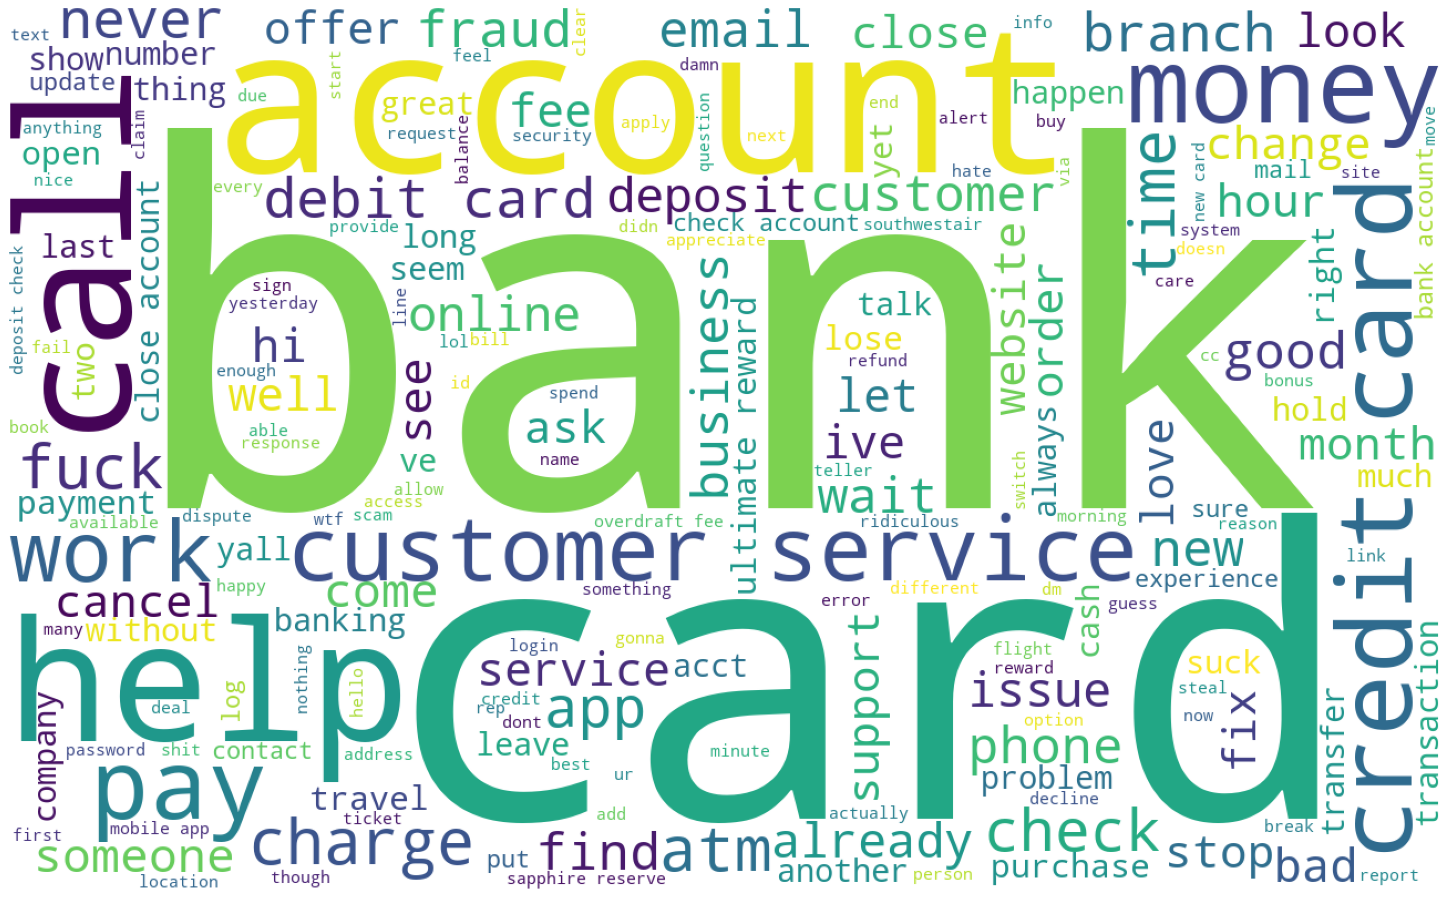

In [40]:
comment_words = '' 

for val in chase_support['interaction_tweet']:     
    val = str(val) 
    tokens = val.split() 
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 1300,height = 800,background_color ='white',min_font_size = 10).generate(comment_words) 
                    
plt.figure(figsize = (20, 20), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

As you can see above, several negative words are frequently used by the customers (you would need to see around the biggest ones) indicating that not all customers are 100% satisfied with the service or with the bank itself. This could be due to multiple reasons and we can't blame the customer service at all. An unsatisfied customer is linked to several metrics, not only how they have been treated by the support team. To determine the root cause, a deeper study should be implemented.

Let's cluster all these tweets and see what shape they take. This could be helpful to determine how the support teams could be segmented (a very frequent strategy adopted in customer support is to create several 'skillset' teams).

# Tweets' topic modeling

## Vectorization
Let's implement **TFIDF Vectorizer** which is known by deliver good results. Let's introduce some theory about it:

One of the best approaches when working with text data is to rescale features by how informative we expect them to be. One of the most common ways to do this is using the term frequency–inverse document frequency (tf–idf) method. The intuition of this method is to give high weight to any term that appears often in a particular document, but not in many documents in the corpus. If a word
appears often in a particular document, but not in very many documents, it is likely to be very descriptive of the content of that document.

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

#We'll implement the ngram_range the way it is because this way the corpus becomes more informative. It's not the same to say 'fraud' than 'Chase is fraud', right?
vect = TfidfVectorizer(ngram_range=(2,3), max_features=20000).fit(chase_support['interaction_tweet'])
data = vect.fit_transform(chase_support['interaction_tweet'])
vect_feature_names = vect.get_feature_names()

## Topic Modeling through Clustering

We won't go too deep in this stage because the project does not require it, but in a real world scenario we would need to implement some research about, for example, find the best number of clusters for our model; but for this particular example, the business is the one that should define the number of clusters depending on the model output. Sometimes it makes more sense this way.

We'll implement NMF model because it's known to deliver good results and also train in short time period. Let's see what patterns it finds in the data.

In [42]:
# NMF : Non-negative matrix factorization (NMF or NNMF),
nmf = NMF(n_components=8, random_state=0, alpha=.1, l1_ratio=.5,max_iter=10000).fit(data)

### How are the topics distributed?

In [43]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 20
print('NMF')
display_topics(nmf, vect_feature_names, no_top_words)

NMF
Topic 0:
customer service, bad customer service, bad customer, best customer service, best customer, customer service rep, service rep, terrible customer service, terrible customer, call customer service, call customer, great customer service, great customer, customer service suck, service suck, poor customer service, poor customer, horrible customer service, horrible customer, customer service help
Topic 1:
credit card, new credit card, new credit, pay credit card, pay credit, credit card account, card account, credit card bill, card bill, credit card number, card number, apply credit, apply credit card, credit card application, card application, credit card fraud, card credit, card fraud, card credit card, credit history
Topic 2:
debit card, new debit card, new debit, lose debit, lose debit card, replacement debit, replacement debit card, cyber monday, debit card hack, card hack, debit card number, debit card cancel, card cancel, order new, card u200d, card pretty, card wait, ord

# Topics' interpretation

Alright, we've reached the end of this notebook. To summarize, as you can see above all topics make sense and this is how we could wrap them up if we would be required to provide a solution to segment teams within the customer support:

* Topic 0: all tweets that contain those keywords must be attended by a team that receives **Customer Support's Complaints** - Which attends upset clients that have had bad experiences with the support service, just like a help desk team would provide attention to "reopened" tickets.
* Topic 1: all tweets in this category would need to be assisted by **Credit Card inquiries** team, and possibly the support would be continued by DM, to avoid any kind of fraud afterwards.
* Topic 2: all tweets that fit this category must be assisted by **Debit Card inquires** team and same as before, continue the process through DM.
* Topic 3: **Ultimate Reward and other Customer Benefits** or something like that, and this team would assist all inquiries related to the benefits the bank provides to its customers.
* Topic 4: This topic could be interpreted as a negative one, and could be attended by **Customer Retention** team.
* Topic 5: This is also a very sensitive topic, which could be attended by **Customer Retention** team or directly a team that handles the **Banking Services's Complaints**
* Topic 6: Sapphire credit cards are provided to top clients, so definitely this topic would be assisted by **VIP Support** team.
* Topic 7: This is very clear, and would be interpreted as **Account operations**.

# Conclusions

Even when the data is not labeled, we can see above what are the words and topics more discussed in the customer support service at Twitter. Applying the same methods, the business could extract the core subjects to get insights about their service and therefore, deploy some solutions - for example, a link with a how-to guide about how to self-resolve most recurrent issues - or how to know if a tweet is crucial to be answered ASAP or not. In addition, if going further would be required, the next step would be to label this data and build a predictor with a similar vectorizer to then create a chatbot. The solutions will depend on the business' needs.

In general terms and as shown before, the ChaseSupport tweets demostrate a very bad customer support, with very high time-to-response rates and if you take a close look to the words' cloud you will find recurrent terminology that would indicate a negative sentiment in the clients' interactions.

In the case the business would need to increase the customer service NPS (or any other similar parameter), the 10.000-feet-above best way would be to reduce the time-to-response is to segment the support service into micro-teams, each one focusing on different topics, that way all pain points are covered.

Finally, to achieve better results, maybe LDA must be implemented or even any Deep Learning model but again, all this in a real business scenario.

Hope you've enjoyed the read.